# Escuela de ML y DL Módulo 2
# Tarea 4. RNN para el análisis de sentimientos en tweets
# Arnoldo Fernando Chue Sánchez
# arnoldwork20@gmail.com
# Agosto de 2024

## Contenido
1. Planteamiento del problema
2. Planteamiento de la solución
3. Ejemplo de ejecución
4. Conclusiones
5. Referencias

## 1. Planteamiento del problema

Usando la libreta de sentimientos (enojo, alegría, neutralidad, etc.) con la RNN (explicada en la sesión 6 y 7), deberá realizar lo siguiente:
- Usar el dataset airlines_tweets.zip para realizar un análisis de sentimientos
- Crear un modelo de RNN entrenado para hacer clasificación multiclase
- Hacer un par de pruebas con textos de su autoría y hacer un reporte de los resultados

NOTA: Se calificará también su análisis del dataset; su analogía y razonamiento de qué columnas usar y cuáles descartar. A diferencia de la clase que se vio una clasificación binaria, este dataset es multiclase.lase.

## 2. Planteamiento de la solución

En primer lugar importamos algunas de las librerías que vamos a necesitar:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Específicamente para esta práctica necesitamos herramientas para procesar el lenguaje natural, por lo que agregamos la librería nltk

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fernando\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fernando\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Fernando\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Fernando\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Fernando\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

También verifiquemos que disponemos de la GPU

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
Path = ""

Comenzemos con la exploración de nuestros datos. Lo primero es que descomprimimos el .zip y optamos por usar el csv en lugar del SQL para agilizar el análisis

In [8]:
df1 = pd.read_csv(Path+"Tweets.csv")

In [9]:
df1.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [9]:
df1.shape

(14640, 15)

Como podemos ver tenemos muchas columnas y realmente no vamos a utilizar todas. Puede que algunas nos den información sobre cómo está conformado el dataset. Además, algunas nos pueden servir para quedarnos con tweets que realmente sirvan para entrenar nuestra red neuronal. Por lo que primero podemos explorar y limpiar el dataset.

La primera que podemos eliminar es la de tweet_id, ya que es un identificador que no aporta información

In [10]:
df1.drop(labels="tweet_id", axis=1, inplace=True)

In [10]:
df1.tail()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


Como podemos ver tenemos 3 categorías para los tweets: positivo, negativo y neutral. De modo que la columna "airline_sentiment" es la etiqueta y el texto de la columna "text" es lo que le vamos a dar a la red neuronal.

Para la parte del análisis podemos comenzar a explorar columnas de información de los tweets para explorar el dataset.

In [23]:
df1['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [11]:
positivos = df1[df1["airline_sentiment"] == "positive"]
negativos = df1[df1["airline_sentiment"] == "negative"]
neutrales = df1[df1["airline_sentiment"] == "neutral"]

Al contar las frecuencias de las categorías de las etiquetas vemos que el dataset está muy desbalanceado. Puede que con la limpieza se logre mejorar esto. Sin embargo, sí es un factor a tomar en cuenta

Analizamos user_timezone

In [14]:
df1["user_timezone"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 14640 entries, 0 to 14639
Series name: user_timezone
Non-Null Count  Dtype 
--------------  ----- 
9820 non-null   object
dtypes: object(1)
memory usage: 114.5+ KB


In [17]:
print(f"{round(100-9820*100/14640, 2)}% de datos nulos")

32.92% de datos nulos


In [35]:
print(f"{negativos[negativos['user_timezone'].isna()].shape[0]} no nulos en los negativos")
print(f"{neutrales[neutrales['user_timezone'].isna()].shape[0]} no nulos en los neutrales")
print(f"{positivos[positivos['user_timezone'].isna()].shape[0]} no nulos en los positivos")

3170 no nulos en los negativos
971 no nulos en los neutrales
679 no nulos en los positivos


Vemos que las frecuencias se mantienen iguales. Por lo que esta columna la podemos eliminar porque ni la vamos a usar para el entrenamiento de la red neuronal y tampoco nos dio información para balancear el dataset ni para limpiarlo

In [12]:
df1.drop(labels="user_timezone", axis=1, inplace=True)

In [39]:
df1.iloc[345:351,:]

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location
345,negative,0.6558,Late Flight,0.6558,Virgin America,NaN,bonniecamp,NaN,1,@VirginAmerica spending my birthday night with...,NaN,2015-02-19 14:06:59 -0800,NaN
346,negative,0.6596,Customer Service Issue,0.3617,Virgin America,NaN,GaySkiWeek,NaN,0,@VirginAmerica Sent a couple messages to the e...,NaN,2015-02-19 13:45:37 -0800,"Telluride, CO"
347,positive,1.0000,NaN,NaN,Virgin America,NaN,graveyardtravel,NaN,0,"@VirginAmerica first time flying Virgin, went ...",NaN,2015-02-19 13:39:45 -0800,"Portland, Oregon"
348,negative,0.6436,Can't Tell,0.3240,Virgin America,NaN,taygarrett,NaN,0,"@VirginAmerica seriously, though. will there n...",NaN,2015-02-19 13:27:10 -0800,san francisco
349,negative,0.3617,Flight Booking Problems,0.3617,Virgin America,NaN,jamonholmgren,NaN,0,@VirginAmerica It's fine. Already done with my...,NaN,2015-02-19 13:18:18 -0800,"Vancouver, WA"
350,negative,1.0000,Bad Flight,0.6723,Virgin America,NaN,BlackFlagShoppe,NaN,0,@virginamerica not really the experience I was...,NaN,2015-02-19 13:14:23 -0800,”Straight Outta Jersey”


Podemos analizar la columna "name". Parece ser el nombre de usuario de la persona que escribió el tweet. Puede que si alguien escribió demasiados tweets del mismo tipo, nos ayude a eliminar algunas de esas filas y balancear un poco el dataset

In [42]:
df1['name'].value_counts()

name
JetBlueNews       63
kbosspotter       32
_mhertz           29
otisday           28
throthra          27
                  ..
ChrisJLeary        1
tracy_edes         1
NGottesman         1
chadlacalamita     1
sanyabun           1
Name: count, Length: 7701, dtype: int64

In [47]:
df1[df1["name"] == "JetBlueNews"]["airline_sentiment"].value_counts()

airline_sentiment
neutral     57
positive     5
negative     1
Name: count, dtype: int64

In [48]:
df1[df1["name"] == "kbosspotter"]["airline_sentiment"].value_counts()

airline_sentiment
neutral     22
positive     6
negative     4
Name: count, dtype: int64

In [49]:
df1[df1["name"] == "_mhertz"]["airline_sentiment"].value_counts()

airline_sentiment
negative    27
neutral      2
Name: count, dtype: int64

In [50]:
df1[df1["name"] == "otisday"]["airline_sentiment"].value_counts()

airline_sentiment
negative    28
Name: count, dtype: int64

Como podemos ver algunos son neutrales porque probablemente son cuentas que son para hablar directamente de aerolineas. Sin embargo, otras sí son cuentas que aportan mucho a los tweets negativos. Dado que no es ruido como tal el que generan, no vale la pena borrarlos del dataset sus registros. Sin embargo, para ahorrar memoria sí vamos a borrar el nombre del usuario del dataframe de pandas.

In [13]:
df1.drop(labels="name", axis=1, inplace=True)

In [52]:
df1.iloc[1234:1240,:]

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location
1234,positive,1.0000,NaN,NaN,United,NaN,NaN,0,@united has the best customer experience via t...,NaN,2015-02-23 06:54:57 -0800,"Cambridge, MA"
1235,neutral,0.6767,NaN,NaN,United,NaN,NaN,0,@united Thank you for your response!,NaN,2015-02-23 06:54:50 -0800,"Albuquerque, New Mexico"
1236,negative,1.0000,Bad Flight,0.6742,United,NaN,NaN,0,@united Flight 683 last night was #bad4busines...,NaN,2015-02-23 06:54:20 -0800,canton mi\n
1237,negative,1.0000,Customer Service Issue,0.3803,United,NaN,NaN,0,@united Beyond frustrated Sked change = no se...,NaN,2015-02-23 06:50:49 -0800,"Ashburn, VA"
1238,negative,1.0000,Flight Booking Problems,0.3564,United,NaN,NaN,0,@united working with Lisa J at ORD. she's work...,"[41.97883697, -87.90639116]",2015-02-23 06:48:32 -0800,chicago
1239,positive,1.0000,NaN,NaN,United,NaN,NaN,0,@united love the new 1st class breakfast!,NaN,2015-02-23 06:46:05 -0800,NaN


Lo que sigue es eliminar la columna de las coordenadas del tweet. Esto porque a nivel de interpretabilidad no nos da buena información; en todo caso es mejor quedarnos con la columna de tweet_location porque es más fácil de interpretar.

In [14]:
df1.drop(labels="tweet_coord", axis=1, inplace=True)

Ahora bien, en cuanto a la fecha del tweet, no nos sirve para filtrar datos para la red neuronal. Sin embargo, podemos analizar cuáles han sido las fechas de este dataset con mayor número de comentarios negativos (a manera de exploración del dataset).

In [54]:
negativos["tweet_created"].info()

<class 'pandas.core.series.Series'>
Index: 9178 entries, 3 to 14638
Series name: tweet_created
Non-Null Count  Dtype 
--------------  ----- 
9178 non-null   object
dtypes: object(1)
memory usage: 143.4+ KB


In [15]:
negativos["tweet_created"] = negativos["tweet_created"].apply(lambda x: x[:10])

In [57]:
negativos["tweet_created"].value_counts()

tweet_created
2015-02-22    2266
2015-02-23    1919
2015-02-21    1049
2015-02-17     838
2015-02-20     835
2015-02-24     781
2015-02-19     751
2015-02-18     736
2015-02-16       3
Name: count, dtype: int64

In [16]:
df1["tweet_created"] = df1["tweet_created"].apply(lambda x: x[:10])

In [60]:
df1["tweet_created"].value_counts()

tweet_created
2015-02-22    3079
2015-02-23    3028
2015-02-21    1557
2015-02-20    1500
2015-02-17    1408
2015-02-19    1376
2015-02-24    1344
2015-02-18    1344
2015-02-16       4
Name: count, dtype: int64

Como podemos ver, las semanas del 16 de febrero de 2015 al 24 de febrero de 2015 constituyen a este dataset. Donde los día con más tweets negativos fue el 22 de febrero.

In [62]:
df1.iloc[9850:9856,:]

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,retweet_count,text,tweet_created,tweet_location
9850,negative,0.6403,longlines,0.6403,US Airways,NaN,NaN,0,@USAirways What is happening at Reagan Airport...,2015-02-22,NaN
9851,negative,1.0000,Damaged Luggage,1.0000,US Airways,NaN,NaN,0,"@USAirways @AuroraBIZ check your bag, @PHLAirp...",2015-02-22,NaN
9852,negative,0.6445,Customer Service Issue,0.6445,US Airways,NaN,NaN,0,@usairways hopefully your crappy service impro...,2015-02-22,"St. Augustine, Florida"
9853,negative,1.0000,longlines,0.6831,US Airways,NaN,NaN,0,@usairways 2 people working the counter at #dc...,2015-02-22,"St. Augustine, Florida"
9854,neutral,1.0000,NaN,NaN,US Airways,NaN,NaN,0,@USAirways what's going on in CLT?,2015-02-22,SC
9855,negative,0.6721,Lost Luggage,0.6721,US Airways,NaN,NaN,0,@USAirways @USAirwaysCenter My lost bag lands ...,2015-02-22,San Francisco


Para la columna retweet_count podemos ver si nos indica algún patrón sobre si los tweets más compartidos pertenecen a alguna de las 3 categorías en específico, es decir, si hay una correlación entre ellas.

In [70]:
df1.sort_values(["retweet_count"], axis=0, ascending=False)

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,retweet_count,text,tweet_created,tweet_location
11596,negative,1.0000,Late Flight,1.0000,US Airways,NaN,NaN,44,@USAirways 5 hr flight delay and a delay when ...,2015-02-17,NaN
11582,negative,1.0000,Can't Tell,0.6608,US Airways,NaN,NaN,32,@USAirways of course never again tho . Thanks ...,2015-02-17,NaN
7132,negative,1.0000,Can't Tell,1.0000,Delta,NaN,NaN,31,STOP. USING.THIS.WORD. IF. YOU'RE. A. COMPANY....,2015-02-23,"New York, NY"
9999,neutral,0.6593,NaN,NaN,US Airways,NaN,NaN,28,@USAirways with this livery back in the day. h...,2015-02-22,Airports Around The World
5607,positive,1.0000,NaN,NaN,Southwest,NaN,NaN,22,@SouthwestAir beautiful day in Seattle! http:/...,2015-02-20,"Bellevue, WA"
...,...,...,...,...,...,...,...,...,...,...,...
5112,negative,1.0000,Late Flight,1.0000,Southwest,NaN,NaN,0,@SouthwestAir why am I still in Baltimore?! @d...,2015-02-21,"Tallahassee, FL"
5113,neutral,1.0000,NaN,NaN,Southwest,NaN,NaN,0,@SouthwestAir I'm ready for #MayweatherPacquia...,2015-02-21,Orlando.South Beach.Vegas
5114,negative,1.0000,Cancelled Flight,1.0000,Southwest,NaN,NaN,0,"@SouthwestAir you have the worst service, you ...",2015-02-21,"Havertown, Pa."
5115,negative,0.6480,Cancelled Flight,0.6480,Southwest,NaN,NaN,0,@SouthwestAir my flight was Cancelled Flighted...,2015-02-21,"Houston, Texas"


Parece que en este caso los 3 tweets más compartidos sí son negativos los 3. Sin embargo, no parece haber evidencia sólida para demostrar que los más o menos compartidos pertenecen a cierta categoría. (Habría que hacer pruebas estadísticas estrictamente hablando, pero al menos al filtrar los datos no parece haberlo).

Por último, antes de pasar a los criterios para filtrar los tweets que sí vamos a usar para la red neuronal, veamos con gráficos cuáles aerolíneas tienen más comentarios negativos y positivos.

In [74]:
df1["airline"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 14640 entries, 0 to 14639
Series name: airline
Non-Null Count  Dtype 
--------------  ----- 
14640 non-null  object
dtypes: object(1)
memory usage: 114.5+ KB


No tenemos datos nulos.

In [75]:
df1["airline"].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

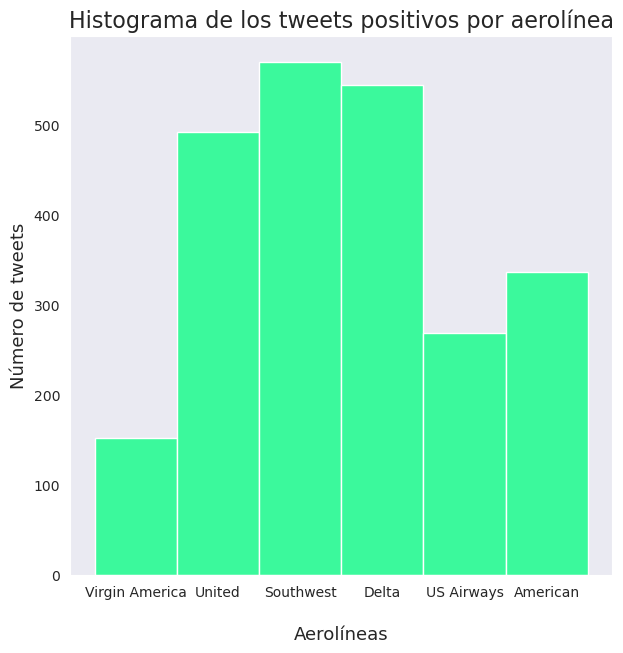

In [17]:
sns.set_style("dark")
plt.figure(figsize=(7,7))
sns.histplot(positivos["airline"], color="springgreen")
plt.ylabel("Número de tweets", size=13)
plt.xlabel("\nAerolíneas", size=13)
plt.title("Histograma de los tweets positivos por aerolínea", size=16)
plt.show()

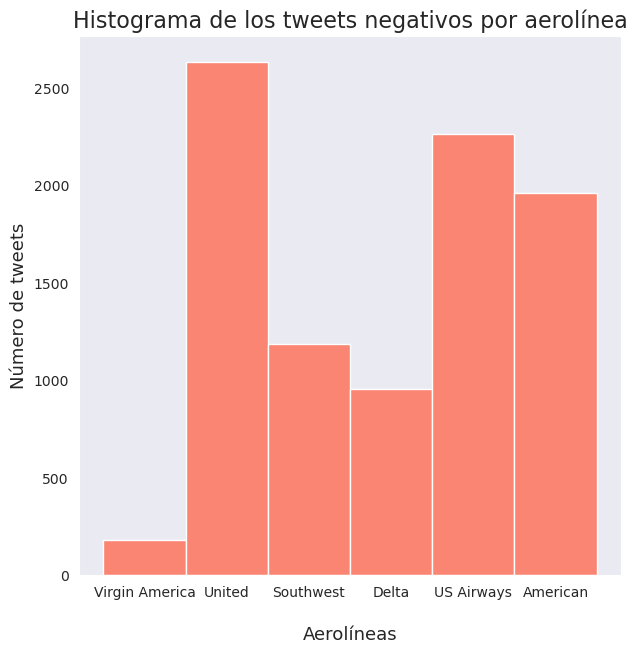

In [18]:
sns.set_style("dark")
plt.figure(figsize=(7,7))
sns.histplot(negativos["airline"], color="tomato")
plt.ylabel("Número de tweets", size=13)
plt.xlabel("\nAerolíneas", size=13)
plt.title("Histograma de los tweets negativos por aerolínea", size=16)
plt.show()

Como podemos ver, aerolíneas como United o American se mantienen casi proporcionales en ambos histogramas. Por otro lado, aerolíneas como Virgin America, Southwest y Delta tienen una proporción menor de comentarios negativos en comparación con los positivos con respecto a las demás aerolíneas. Sin embargo, US Airways sí tiene una proporción mayor de comentarios negativos que positivos.

In [20]:
df1

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,retweet_count,text,tweet_created,tweet_location
0,neutral,1.0000,NaN,NaN,Virgin America,NaN,NaN,0,@VirginAmerica What @dhepburn said.,2015-02-24,NaN
1,positive,0.3486,NaN,0.0000,Virgin America,NaN,NaN,0,@VirginAmerica plus you've added commercials t...,2015-02-24,NaN
2,neutral,0.6837,NaN,NaN,Virgin America,NaN,NaN,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24,Lets Play
3,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,NaN,0,@VirginAmerica it's really aggressive to blast...,2015-02-24,NaN
4,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,NaN,0,@VirginAmerica and it's a really big bad thing...,2015-02-24,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14635,positive,0.3487,NaN,0.0000,American,NaN,NaN,0,@AmericanAir thank you we got on a different f...,2015-02-22,NaN
14636,negative,1.0000,Customer Service Issue,1.0000,American,NaN,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,2015-02-22,Texas
14637,neutral,1.0000,NaN,NaN,American,NaN,NaN,0,@AmericanAir Please bring American Airlines to...,2015-02-22,"Nigeria,lagos"
14638,negative,1.0000,Customer Service Issue,0.6659,American,NaN,NaN,0,"@AmericanAir you have my money, you change my ...",2015-02-22,New Jersey


Veamos si hay datos nulos en las columna de texto o en las etiquetas

In [21]:
df1['airline_sentiment'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 14640 entries, 0 to 14639
Series name: airline_sentiment
Non-Null Count  Dtype 
--------------  ----- 
14640 non-null  object
dtypes: object(1)
memory usage: 114.5+ KB


In [22]:
df1["text"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 14640 entries, 0 to 14639
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
14640 non-null  object
dtypes: object(1)
memory usage: 114.5+ KB


No hay nulos en estas columnas.

Ahora veamos si hay nulos en las columnas que nos dicen con cuánta confianza se tiene categorizado el tweet.

In [24]:
df1['airline_sentiment_confidence'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 14640 entries, 0 to 14639
Series name: airline_sentiment_confidence
Non-Null Count  Dtype  
--------------  -----  
14640 non-null  float64
dtypes: float64(1)
memory usage: 114.5 KB


In [25]:
negativos["negativereason_confidence"].info()

<class 'pandas.core.series.Series'>
Index: 9178 entries, 3 to 14638
Series name: negativereason_confidence
Non-Null Count  Dtype  
--------------  -----  
9178 non-null   float64
dtypes: float64(1)
memory usage: 143.4 KB


No hay nulos, así que podemos ver la distribución de los valores para saber si podemos filtrar algunas instancias para quedarnos con las que mejor entrenen al modelo.

In [27]:
df1["airline_sentiment_confidence"].describe()

count    14640.000000
mean         0.900169
std          0.162830
min          0.335000
25%          0.692300
50%          1.000000
75%          1.000000
max          1.000000
Name: airline_sentiment_confidence, dtype: float64

Aquí podemos poner el siguiente criterio: si no hay una confianza igual o superior al 60% en el sentimiento del tweet, lo vamos a eliminar.

In [19]:
df2 = df1[df1["airline_sentiment_confidence"] >= 0.60]
df2["airline_sentiment_confidence"].describe()

count    14402.000000
mean         0.909153
std          0.148251
min          0.603900
25%          0.698800
50%          1.000000
75%          1.000000
max          1.000000
Name: airline_sentiment_confidence, dtype: float64

Con esto eliminamos 638 tweets que nos podían generar ruido por no estar bien catalogados.

In [29]:
negativos['negativereason_confidence'].describe()

count    9178.000000
mean        0.731769
std         0.238276
min         0.312200
25%         0.645300
50%         0.680600
75%         1.000000
max         1.000000
Name: negativereason_confidence, dtype: float64

Podemos dar el mismo criterio: si en los tweets negativos no hay una confianza igual o superior al 60% de que sea negativo, entonces lo eliminamos.

In [29]:
df3 = df2[((df2["airline_sentiment"] == "negative") & (df2["negativereason_confidence"] >= 0.60)) | (df2["airline_sentiment"] != "negative")] 
df3.shape

(12678, 11)

Con esto nos quedamos con un dataset con más confianza sobre las clases asignadas a cada instancia. Ahora bien, solo falta revisar las proporciones en que nos quedaron las clases y verificar a qué se refieren las columnas que tienen la palabra "gold".

In [30]:
df3["airline_sentiment"].value_counts()

airline_sentiment
negative    7389
neutral     2997
positive    2292
Name: count, dtype: int64

Sigue estando desbalanceado, pero no tanto como al inicio.

In [32]:
df3['airline_sentiment_gold'].info()

<class 'pandas.core.series.Series'>
Index: 12678 entries, 0 to 14639
Series name: airline_sentiment_gold
Non-Null Count  Dtype 
--------------  ----- 
33 non-null     object
dtypes: object(1)
memory usage: 198.1+ KB


In [34]:
df3[df3["airline_sentiment_gold"].notnull()]

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,retweet_count,text,tweet_created,tweet_location
1286,negative,1.0000,Late Flight,0.7684,United,negative,Late Flight\nFlight Attendant Complaints,0,"@united I'm aware of the flight details, thank...",2015-02-23,"Arlington, VA"
2017,negative,1.0000,Late Flight,0.6048,United,negative,Late Flight\nLost Luggage,0,@united flighted delayed for hours. 10pm arriv...,2015-02-22,"Atlantic Highlands, NJ"
2135,neutral,1.0000,NaN,NaN,United,neutral,NaN,0,@united I have a question,2015-02-21,NaN
2201,negative,1.0000,Late Flight,0.6478,United,negative,Late Flight,1,@united it's been over 3 hours...at what point...,2015-02-21,NaN
2383,negative,0.9286,Customer Service Issue,0.9286,United,negative,Customer Service Issue,0,@united You shouldn't page o'head that it's be...,2015-02-21,"new york, baby"
3005,negative,1.0000,Can't Tell,0.6870,United,negative,Can't Tell,0,@united couldn't have possibly messed up our t...,2015-02-20,NaN
4206,negative,1.0000,Cancelled Flight,1.0000,United,negative,Cancelled Flight,0,@united So what do you offer now that my fligh...,2015-02-17,Chicago
4525,positive,0.9657,NaN,0.0000,Southwest,positive,NaN,0,@SouthwestAir What an awesome flight Dallas 2 ...,2015-02-23,ny
5183,negative,1.0000,Customer Service Issue,0.7715,Southwest,negative,Customer Service Issue,0,"@SouthwestAir also, gave up after 1 hr 32 min...",2015-02-21,NaN
5341,negative,1.0000,Customer Service Issue,0.9256,Southwest,negative,Customer Service Issue,0,@SouthwestAir I've been on hold for over an ho...,2015-02-21,"Baton Rouge, LA"


Parece que esta etiqueta es de tweets que están muy seguros sobre la etiqueta. Sin embargo, aun cuando esta interpretación sea incorrecta, sólo hay 33 instancias con esta columna no nula. Por lo que al tener tantos datos nulos la vamos a eliminar.

In [35]:
df3.drop(labels="airline_sentiment_gold", axis=1, inplace=True)

In [36]:
df3["negativereason_gold"].info()

<class 'pandas.core.series.Series'>
Index: 12678 entries, 0 to 14639
Series name: negativereason_gold
Non-Null Count  Dtype 
--------------  ----- 
25 non-null     object
dtypes: object(1)
memory usage: 198.1+ KB


El mismo caso con la negativa: solamente 25 datos no nulo. La podemos eliminar.

In [37]:
df3.drop(labels="negativereason_gold", axis=1, inplace=True)

Con esto podemos concluir la exploración del dataset y podemos comenzar a preparar las palabras:

In [38]:
df3.to_csv(Path+"Tweets_limpio.csv", index=False)

Comenzamos con las funciones para quitar signos de puntuación, caracteres especiales y las stop words. Así como la aplicación de la lematización.

In [128]:
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_specialchars(text):
    return re.sub("[^a-zA-Z0-9]"," ",text)

def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower() 
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)

def cleaning(text):
    text = remove_punctuations(text)
    text = remove_specialchars(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

In [8]:
df3['text'].head(15)

0                   @VirginAmerica What @dhepburn said.
1     @VirginAmerica I didn't today... Must mean I n...
2     @VirginAmerica it's really aggressive to blast...
3     @VirginAmerica and it's a really big bad thing...
4     @VirginAmerica seriously would pay $30 a fligh...
5     @VirginAmerica yes, nearly every time I fly VX...
6     @VirginAmerica Really missed a prime opportuni...
7       @virginamerica Well, I didn't…but NOW I DO! :-D
8     @VirginAmerica it was amazing, and arrived an ...
9     @VirginAmerica did you know that suicide is th...
10    @VirginAmerica I &lt;3 pretty graphics. so muc...
11    @VirginAmerica This is such a great deal! Alre...
12    @VirginAmerica @virginmedia I'm flying your #f...
13                               @VirginAmerica Thanks!
14    @VirginAmerica So excited for my first cross c...
Name: text, dtype: object

In [9]:
df3["text"] = df3["text"].apply(cleaning)

In [10]:
df3['text'].head(15)

0                           virginamerica dhepburn said
1     virginamerica today must mean need take anothe...
2     virginamerica really aggressive blast obnoxiou...
3                    virginamerica really big bad thing
4     virginamerica seriously would pay 30 flight se...
5     virginamerica yes nearly every time fly vx ear...
6     virginamerica really missed prime opportunity ...
7                                    virginamerica well
8         virginamerica amazing arrived hour early good
9     virginamerica know suicide second leading caus...
10    virginamerica lt 3 pretty graphic much better ...
11    virginamerica great deal already thinking 2nd ...
12    virginamerica virginmedia flying fabulous sedu...
13                                 virginamerica thanks
14    virginamerica excited first cross country flig...
Name: text, dtype: object

Con esto podemos comenzar a definir parámetros como el tamaño del vocabulario, tamaño de los vectores con los que representaremos cada palabra del vocabulario, la longitud máxima de secuencias de texto

In [11]:
vocabulario = set([word for tweet in df3.text for word in tweet.split(" ") ])
print(len(vocabulario))

12907


In [12]:
longitud = 0
for tweet in df3.text: longitud = max(longitud, len(tweet.split(" ")))
print(longitud)

26


In [13]:
longitud = 0
for tweet in df3.text: longitud = max(longitud, len(tweet))
print(longitud)

139


In [45]:
vocab_size = 11000 # solamente vamos a tomar las 11000 palabras más populares
embedding_dim = 15 # vamos a crear vectores de tamaño 15 para cada palabra
max_length = 20 # maxima cantidad de palabras que van a entrar por tweet, dado que el más largo tiene 26
trunc_type = 'post' 

Pasemos ahora a crear los conjuntos de entrenamiento, validación y pruebas. Vamos a darle 70% para entrenamiento, 15% para validación y 15% para prueba

In [108]:
train, val_test = train_test_split(df3[["text", "airline_sentiment"]], test_size=0.3, random_state=2006)

Xtrain, Ytrain = list(train["text"]), np.array(list(train["airline_sentiment"]))

val, test = train_test_split(val_test, test_size=0.5, random_state=2006)

Xval, Yval = list(val["text"]), np.array(list(val["airline_sentiment"]))
Xtest, Ytest = list(test["text"]), np.array(list(val["airline_sentiment"]))

In [140]:
encoder = LabelEncoder()
encoder.fit_transform(Ytrain)
Ytrain, Yval, Ytest = encoder.transform(Ytrain), encoder.transform(Yval), encoder.transform(Ytest)

Terminemos la representación vectorial de los tweets para poderlos pasar por la red neuronal

In [110]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(Xtrain)

word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(Xtrain)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

valid_sequences = tokenizer.texts_to_sequences(Xval)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(Xtest)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

Con esto finalmente podemos comenzar con las redes neuronales recurrentes:

**Primera propuesta de arquitectura**: Usaremos neuronas GRU (gated recurrent unit), específicamente 64 en una capa bidireccional. Después agregaremos una capa densa de 300 neuronas con regularización L1 = 0.05 (para no comenzar tan estrictos), función de activatión relu y un dropout de 0.3. Repetimos esta capa con 100 neuronas, pero ahora en lugar del dropout agregamos una capa de normalización, para finalmente llegar a la capa de salida con sus 3 neuronas para cada clase y su función softmax. En este caso vamos a usar adam como optimizador y solamente 7 épocas para probar esta primera arquitectura.

In [51]:
model1 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.GRU(64)),
    keras.layers.Dense(300, kernel_regularizer=keras.regularizers.l1(0.05), activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.05), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='softmax')
])

In [52]:
model1.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [53]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 15)            165000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              31104     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 300)               38700     
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_13 (Dense)            (None, 100)               30100     
                                                                 
 batch_normalization_4 (Batc  (None, 100)              400       
 hNormalization)                                      

In [54]:
num_epochs = 7
history1 = model1.fit(
    train_padded,
    Ytrain,
    epochs=num_epochs,
    validation_data=(valid_padded, Yval))

Epoch 1/7
278/278 [==============================] - 9s 21ms/step - loss: 31.8162 - accuracy: 0.5864 - val_loss: 1.4346 - val_accuracy: 0.5789
Epoch 2/7
278/278 [==============================] - 5s 18ms/step - loss: 1.2302 - accuracy: 0.6725 - val_loss: 1.2617 - val_accuracy: 0.6241
Epoch 3/7
278/278 [==============================] - 5s 18ms/step - loss: 1.1199 - accuracy: 0.7297 - val_loss: 1.1743 - val_accuracy: 0.6966
Epoch 4/7
278/278 [==============================] - 5s 18ms/step - loss: 1.0584 - accuracy: 0.7594 - val_loss: 1.2091 - val_accuracy: 0.6961
Epoch 5/7
278/278 [==============================] - 5s 18ms/step - loss: 1.0173 - accuracy: 0.7792 - val_loss: 1.2724 - val_accuracy: 0.6998
Epoch 6/7
278/278 [==============================] - 5s 18ms/step - loss: 0.9971 - accuracy: 0.7950 - val_loss: 1.2379 - val_accuracy: 0.7187
Epoch 7/7
278/278 [==============================] - 5s 18ms/step - loss: 0.9508 - accuracy: 0.8295 - val_loss: 1.3321 - val_accuracy: 0.7061


Como podemos ver, el modelo está entrenando y aprendiendo exitosamente. Ahora es cuestión de mejorar la arquitectura del modelo para subir la efectividad sin sobreajustar. Además usaremos checkpoints para guardar el mejor modelo a través de las épocas.

In [55]:
model1.save("modelo1_tarea4.hdf5")

In [56]:
filepath = "modelo1_tarea4.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Una vez hecho lo anterior podemos darle más épocas de entrenamiento al primero modelo. Por ser el optimizador adam podemos subir a 15, esperando que no se sobreajuste.

In [57]:
num_epochs = 15
history1 = model1.fit(
    train_padded,
    Ytrain,
    epochs=num_epochs,
    validation_data=(valid_padded, Yval),
    callbacks=callbacks_list  
)

Epoch 1/15
278/278 [==============================] - 5s 20ms/step - loss: 0.9065 - accuracy: 0.8600 - val_loss: 1.3571 - val_accuracy: 0.7061
Epoch 2/15
278/278 [==============================] - 5s 20ms/step - loss: 0.8783 - accuracy: 0.8725 - val_loss: 1.3492 - val_accuracy: 0.7119
Epoch 3/15
278/278 [==============================] - 5s 19ms/step - loss: 0.8510 - accuracy: 0.8817 - val_loss: 1.3965 - val_accuracy: 0.6993
Epoch 4/15
278/278 [==============================] - 5s 19ms/step - loss: 0.8328 - accuracy: 0.8884 - val_loss: 1.3965 - val_accuracy: 0.7093
Epoch 5/15
278/278 [==============================] - 5s 18ms/step - loss: 0.8073 - accuracy: 0.9015 - val_loss: 1.4521 - val_accuracy: 0.7029
Epoch 6/15
278/278 [==============================] - 5s 20ms/step - loss: 0.7833 - accuracy: 0.9089 - val_loss: 1.4867 - val_accuracy: 0.7156
Epoch 7/15
278/278 [==============================] - 5s 18ms/step - loss: 0.7851 - accuracy: 0.9102 - val_loss: 1.5341 - val_accuracy: 0.7061

En definitiva este modelo parece tener su límite en el 71% de accuracy porque tiende a sobreajustarse.

In [58]:
import shutil
shutil.rmtree(Path + "modelo1_tarea4", ignore_errors=True)
model1.save(Path+"modelo1_tarea4", save_format="tf")

INFO:tensorflow:Assets written to: modelo1_tarea4\assets


INFO:tensorflow:Assets written to: modelo1_tarea4\assets


Pasemos a una nueva arquitectura de RNN:

In [67]:
model2 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.GRU(128)),
    keras.layers.Dense(300, kernel_regularizer=keras.regularizers.l1(0.001), activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(3, activation='softmax')
])

Aquí cambiamos agregando más neuronas GRU, pero reducimos la penalización L1 al ponerla en 0.001 para ser menos tolerantes al minimizar la función de pérdida. Sin embargo, quitamos la capa de normalización y agregamos mejor un dropout de 0.3 a esa última capa para contrarrestar el sobreajuste que se puede dar al tener una penalización tan fuerte.

In [68]:
model2.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 20, 15)            165000    
                                                                 
 bidirectional_10 (Bidirecti  (None, 256)              111360    
 onal)                                                           
                                                                 
 dense_27 (Dense)            (None, 300)               77100     
                                                                 
 dropout_11 (Dropout)        (None, 300)               0         
                                                                 
 dense_28 (Dense)            (None, 100)               30100     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                      

In [69]:
history2 = model2.fit(
    train_padded,
    Ytrain,
    epochs=num_epochs,
    validation_data=(valid_padded, Yval),
    callbacks=callbacks_list  
)

Epoch 1/15
278/278 [==============================] - 14s 33ms/step - loss: 1.7044 - accuracy: 0.6190 - val_loss: 0.7702 - val_accuracy: 0.6656
Epoch 2/15
278/278 [==============================] - 8s 28ms/step - loss: 0.6822 - accuracy: 0.7044 - val_loss: 0.7305 - val_accuracy: 0.6672
Epoch 3/15
278/278 [==============================] - 8s 28ms/step - loss: 0.5751 - accuracy: 0.7510 - val_loss: 0.8189 - val_accuracy: 0.7376
Epoch 4/15
278/278 [==============================] - 8s 27ms/step - loss: 0.5124 - accuracy: 0.8074 - val_loss: 0.8018 - val_accuracy: 0.7277
Epoch 5/15
278/278 [==============================] - 8s 27ms/step - loss: 0.4656 - accuracy: 0.8476 - val_loss: 0.8847 - val_accuracy: 0.7261
Epoch 6/15
278/278 [==============================] - 8s 29ms/step - loss: 0.4121 - accuracy: 0.8744 - val_loss: 1.0106 - val_accuracy: 0.7376
Epoch 7/15
278/278 [==============================] - 10s 34ms/step - loss: 0.3745 - accuracy: 0.8917 - val_loss: 1.0449 - val_accuracy: 0.72

Seguimos presentando sobreajuste ya que las mejores épocas fueron cuando en el conjunto de validación se alcanzó un 73%, mientras que en el entrenamiento se alcanzó por encima del 90%.

In [70]:
shutil.rmtree("modelo2_tarea4", ignore_errors=True)
model2.save("modelo2_tarea4", save_format="tf")

INFO:tensorflow:Assets written to: modelo2_tarea4\assets


INFO:tensorflow:Assets written to: modelo2_tarea4\assets


Para verificar el sobreajuste vamos a subir el droput al 0.5. Lo demás lo podemos mantener igual para ver si con eso se soluciona aunque sea un poco.

In [71]:
model3 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.GRU(128)),
    keras.layers.Dense(300, kernel_regularizer=keras.regularizers.l1(0.001), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

In [73]:
model3.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 20, 15)            165000    
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              111360    
 onal)                                                           
                                                                 
 dense_30 (Dense)            (None, 300)               77100     
                                                                 
 dropout_13 (Dropout)        (None, 300)               0         
                                                                 
 dense_31 (Dense)            (None, 100)               30100     
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                     

In [74]:
history3 = model3.fit(
    train_padded,
    Ytrain,
    epochs=num_epochs,
    validation_data=(valid_padded, Yval),
    callbacks=callbacks_list  
)

Epoch 1/15
278/278 [==============================] - 14s 33ms/step - loss: 1.7437 - accuracy: 0.6165 - val_loss: 0.8005 - val_accuracy: 0.6651
Epoch 2/15
278/278 [==============================] - 9s 31ms/step - loss: 0.7034 - accuracy: 0.7059 - val_loss: 0.7677 - val_accuracy: 0.6751
Epoch 3/15
278/278 [==============================] - 8s 28ms/step - loss: 0.6000 - accuracy: 0.7401 - val_loss: 0.8064 - val_accuracy: 0.6640
Epoch 4/15
278/278 [==============================] - 8s 28ms/step - loss: 0.5402 - accuracy: 0.7583 - val_loss: 0.8466 - val_accuracy: 0.6672
Epoch 5/15
278/278 [==============================] - 8s 27ms/step - loss: 0.4965 - accuracy: 0.7842 - val_loss: 0.8807 - val_accuracy: 0.7129
Epoch 6/15
278/278 [==============================] - 8s 27ms/step - loss: 0.4744 - accuracy: 0.8174 - val_loss: 0.9521 - val_accuracy: 0.7040
Epoch 7/15
278/278 [==============================] - 8s 28ms/step - loss: 0.4470 - accuracy: 0.8544 - val_loss: 1.1243 - val_accuracy: 0.716

In [75]:
shutil.rmtree("modelo3_tarea4", ignore_errors=True)
model3.save("modelo3_tarea4", save_format="tf")

INFO:tensorflow:Assets written to: modelo3_tarea4\assets


INFO:tensorflow:Assets written to: modelo3_tarea4\assets


Claramente seguimos sobreajustando y de hecho, con esta arquitectura no llegamos ni al 73% del modelo anterior. Por lo que vamos a reducir ahora la cantidad de neuronas en la capa recurrente y vamos a bajar la penalización L1

In [76]:
model4 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.GRU(42)),
    keras.layers.Dense(300, kernel_regularizer=keras.regularizers.l1(0.01), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.01), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

In [84]:
model4.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 20, 15)            165000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 84)               14868     
 onal)                                                           
                                                                 
 dense_33 (Dense)            (None, 300)               25500     
                                                                 
 dropout_15 (Dropout)        (None, 300)               0         
                                                                 
 dense_34 (Dense)            (None, 100)               30100     
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                     

Vamos ahora a entrenar con lotes para ver si eso también permite evitar el sobreajuste. Sin embargo, vamos a dar 5 épocas más

In [85]:
num_epochs += 5
history4 = model4.fit(
    train_padded,
    Ytrain,
    epochs=num_epochs,
    batch_size=250,
    validation_data=(valid_padded, Yval),
    callbacks=callbacks_list  
)

Epoch 1/20
36/36 [==============================] - 7s 68ms/step - loss: 0.6850 - accuracy: 0.7774 - val_loss: 1.2193 - val_accuracy: 0.6488
Epoch 2/20
36/36 [==============================] - 1s 33ms/step - loss: 0.6184 - accuracy: 0.7819 - val_loss: 1.1686 - val_accuracy: 0.6467
Epoch 3/20
36/36 [==============================] - 1s 33ms/step - loss: 0.6168 - accuracy: 0.7807 - val_loss: 1.1712 - val_accuracy: 0.6451
Epoch 4/20
36/36 [==============================] - 1s 31ms/step - loss: 0.6129 - accuracy: 0.7810 - val_loss: 1.2123 - val_accuracy: 0.6504
Epoch 5/20
36/36 [==============================] - 1s 32ms/step - loss: 0.6145 - accuracy: 0.7798 - val_loss: 1.2324 - val_accuracy: 0.6530
Epoch 6/20
36/36 [==============================] - 1s 32ms/step - loss: 0.6038 - accuracy: 0.7819 - val_loss: 1.2522 - val_accuracy: 0.6504
Epoch 7/20
36/36 [==============================] - 1s 32ms/step - loss: 0.6082 - accuracy: 0.7817 - val_loss: 1.1753 - val_accuracy: 0.6420
Epoch 8/20
36

In [86]:
shutil.rmtree("modelo4_tarea4", ignore_errors=True)
model4.save("modelo4_tarea4", save_format="tf")

INFO:tensorflow:Assets written to: modelo4_tarea4\assets


INFO:tensorflow:Assets written to: modelo4_tarea4\assets


Con este modelo ahora tenemos un bajo ajuste. Para cambiar el enfoque ahora podemos cambiar de neuronas GRU a LSTM. Sin embargo, vamos a usar más neuronas para evitar el bajo ajuste del modelo anterior

In [87]:
model5 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(300, kernel_regularizer=keras.regularizers.l1(0.01), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.01), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')                         
])

model5.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 20, 15)            165000    
                                                                 
 bidirectional_13 (Bidirecti  (None, 128)              40960     
 onal)                                                           
                                                                 
 dense_36 (Dense)            (None, 300)               38700     
                                                                 
 dropout_17 (Dropout)        (None, 300)               0         
                                                                 
 dense_37 (Dense)            (None, 100)               30100     
                                                                 
 dropout_18 (Dropout)        (None, 100)               0         
                                                     

In [88]:
history5 = model5.fit(
    train_padded,
    Ytrain,
    epochs=num_epochs,
    batch_size=250,
    validation_data=(valid_padded, Yval),
    callbacks=callbacks_list
)

Epoch 1/20
36/36 [==============================] - 8s 79ms/step - loss: 31.5850 - accuracy: 0.5798 - val_loss: 21.3605 - val_accuracy: 0.5789
Epoch 2/20
36/36 [==============================] - 1s 36ms/step - loss: 14.2482 - accuracy: 0.5859 - val_loss: 7.8044 - val_accuracy: 0.5789
Epoch 3/20
36/36 [==============================] - 1s 37ms/step - loss: 4.2546 - accuracy: 0.5859 - val_loss: 1.7410 - val_accuracy: 0.5789
Epoch 4/20
36/36 [==============================] - 1s 35ms/step - loss: 1.2295 - accuracy: 0.5859 - val_loss: 1.0663 - val_accuracy: 0.5789
Epoch 5/20
36/36 [==============================] - 1s 33ms/step - loss: 0.9417 - accuracy: 0.6289 - val_loss: 0.9805 - val_accuracy: 0.6698
Epoch 6/20
36/36 [==============================] - 1s 35ms/step - loss: 0.8734 - accuracy: 0.7325 - val_loss: 0.9488 - val_accuracy: 0.6682
Epoch 7/20
36/36 [==============================] - 1s 36ms/step - loss: 0.8466 - accuracy: 0.7469 - val_loss: 0.9957 - val_accuracy: 0.6677
Epoch 8/20

In [89]:
shutil.rmtree("modelo5_tarea4", ignore_errors=True)
model5.save("modelo5_tarea4", save_format="tf")

INFO:tensorflow:Assets written to: modelo5_tarea4\assets


INFO:tensorflow:Assets written to: modelo5_tarea4\assets


Nuevamente nos quedamos por debajo del 70%. Por lo que vamos a regresar a entrenar con los conjuntos completos pero con 15 épocas. La única modificación será ahora que usaremos la penalización L2 pero con 0.005

In [90]:
num_epochs -= 5
model6 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(300, kernel_regularizer=keras.regularizers.l2(0.005), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l2(0.005), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')                         
])

model6.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 20, 15)            165000    
                                                                 
 bidirectional_14 (Bidirecti  (None, 128)              40960     
 onal)                                                           
                                                                 
 dense_39 (Dense)            (None, 300)               38700     
                                                                 
 dropout_19 (Dropout)        (None, 300)               0         
                                                                 
 dense_40 (Dense)            (None, 100)               30100     
                                                                 
 dropout_20 (Dropout)        (None, 100)               0         
                                                     

In [91]:
history6 = model6.fit(
    train_padded,
    Ytrain,
    epochs = num_epochs,
    validation_data=(valid_padded, Yval),
    callbacks=callbacks_list
)

Epoch 1/15
278/278 [==============================] - 16s 40ms/step - loss: 1.0509 - accuracy: 0.6430 - val_loss: 0.6782 - val_accuracy: 0.7108
Epoch 2/15
278/278 [==============================] - 9s 31ms/step - loss: 0.5716 - accuracy: 0.7702 - val_loss: 0.6737 - val_accuracy: 0.7466
Epoch 3/15
278/278 [==============================] - 8s 29ms/step - loss: 0.4542 - accuracy: 0.8394 - val_loss: 0.7465 - val_accuracy: 0.7366
Epoch 4/15
278/278 [==============================] - 8s 31ms/step - loss: 0.3774 - accuracy: 0.8795 - val_loss: 0.7747 - val_accuracy: 0.7413
Epoch 5/15
278/278 [==============================] - 8s 29ms/step - loss: 0.3179 - accuracy: 0.9066 - val_loss: 0.7834 - val_accuracy: 0.7261
Epoch 6/15
278/278 [==============================] - 8s 29ms/step - loss: 0.2792 - accuracy: 0.9213 - val_loss: 0.8505 - val_accuracy: 0.7408
Epoch 7/15
278/278 [==============================] - 8s 29ms/step - loss: 0.2397 - accuracy: 0.9384 - val_loss: 0.8798 - val_accuracy: 0.743

In [92]:
shutil.rmtree("modelo6_tarea4", ignore_errors=True)
model6.save("model6_tarea4", save_format="tf")

INFO:tensorflow:Assets written to: model6_tarea4\assets


INFO:tensorflow:Assets written to: model6_tarea4\assets


Aquí podemos ver que con la nueva regularización logramos llegar al 75%. Por lo que la siguiente propuesta es aumentar las neuronas en las capas, tanto la recurrente como la densa. Sobre todo hacer más robusta la parte densa.

In [94]:
model7 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(128)),
    keras.layers.Dense(1000, kernel_regularizer=keras.regularizers.l2(0.005), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1000, kernel_regularizer=keras.regularizers.l2(0.005), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(420, kernel_regularizer=keras.regularizers.l2(0.005), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(150, kernel_regularizer=keras.regularizers.l2(0.005), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')                         
])

model7.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model7.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 20, 15)            165000    
                                                                 
 bidirectional_16 (Bidirecti  (None, 256)              147456    
 onal)                                                           
                                                                 
 dense_47 (Dense)            (None, 1000)              257000    
                                                                 
 dropout_25 (Dropout)        (None, 1000)              0         
                                                                 
 dense_48 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_26 (Dropout)        (None, 1000)              0         
                                                     

Nótese que los parámetros casi se multiplicaron por 10

In [95]:
history7 = model7.fit(
    train_padded,
    Ytrain,
    epochs = num_epochs,
    validation_data=(valid_padded, Yval),
    callbacks=callbacks_list    
)

Epoch 1/15
278/278 [==============================] - 16s 39ms/step - loss: 1.6438 - accuracy: 0.6152 - val_loss: 0.7578 - val_accuracy: 0.6604
Epoch 2/15
278/278 [==============================] - 9s 32ms/step - loss: 0.6784 - accuracy: 0.7014 - val_loss: 0.7348 - val_accuracy: 0.6630
Epoch 3/15
278/278 [==============================] - 9s 31ms/step - loss: 0.5866 - accuracy: 0.7406 - val_loss: 0.7402 - val_accuracy: 0.7245
Epoch 4/15
278/278 [==============================] - 9s 31ms/step - loss: 0.5192 - accuracy: 0.7915 - val_loss: 0.7819 - val_accuracy: 0.6972
Epoch 5/15
278/278 [==============================] - 9s 31ms/step - loss: 0.4826 - accuracy: 0.8185 - val_loss: 0.8609 - val_accuracy: 0.7087
Epoch 6/15
278/278 [==============================] - 9s 31ms/step - loss: 0.4450 - accuracy: 0.8411 - val_loss: 1.1592 - val_accuracy: 0.7245
Epoch 7/15
278/278 [==============================] - 9s 32ms/step - loss: 0.3997 - accuracy: 0.8742 - val_loss: 1.1675 - val_accuracy: 0.708

In [96]:
shutil.rmtree("modelo7_tarea4", ignore_errors=True)
model7.save("modelo7_tarea4", save_format="tf")

INFO:tensorflow:Assets written to: modelo7_tarea4\assets


INFO:tensorflow:Assets written to: modelo7_tarea4\assets


Como vemos, aumentar la complejidad del modelo no es garantía de un mejor desempeño. Por lo tanto, para contrarrestar este sobreajuste, vamos a subir la regularización

In [124]:
model8 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(128)),
    keras.layers.Dense(1000, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1000, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(420, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(150, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')                         
])

model8.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model8.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 20, 15)            165000    
                                                                 
 bidirectional_18 (Bidirecti  (None, 256)              147456    
 onal)                                                           
                                                                 
 dense_57 (Dense)            (None, 1000)              257000    
                                                                 
 dropout_33 (Dropout)        (None, 1000)              0         
                                                                 
 dense_58 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_34 (Dropout)        (None, 1000)              0         
                                                     

In [125]:
history8 = model8.fit(
    train_padded,
    Ytrain,
    epochs = num_epochs,
    validation_data=(valid_padded, Yval),
    callbacks=callbacks_list    
)

Epoch 1/15


278/278 [==============================] - 16s 38ms/step - loss: 2.3799 - accuracy: 0.6004 - val_loss: 0.8204 - val_accuracy: 0.6682
Epoch 2/15
278/278 [==============================] - 9s 32ms/step - loss: 0.6956 - accuracy: 0.7064 - val_loss: 0.7532 - val_accuracy: 0.6540
Epoch 3/15
278/278 [==============================] - 10s 36ms/step - loss: 0.5986 - accuracy: 0.7398 - val_loss: 0.8892 - val_accuracy: 0.6598
Epoch 4/15
278/278 [==============================] - 9s 31ms/step - loss: 0.5444 - accuracy: 0.7599 - val_loss: 0.7678 - val_accuracy: 0.6951
Epoch 5/15
278/278 [==============================] - 9s 31ms/step - loss: 0.5079 - accuracy: 0.7874 - val_loss: 1.0188 - val_accuracy: 0.7145
Epoch 6/15
278/278 [==============================] - 8s 30ms/step - loss: 0.4825 - accuracy: 0.8230 - val_loss: 0.9334 - val_accuracy: 0.7045
Epoch 7/15
278/278 [==============================] - 8s 30ms/step - loss: 0.4694 - accuracy: 0.8414 - val_loss: 0.8851 - val_accuracy: 0.6882
Epoch 8/

In [157]:
shutil.rmtree("modelo8_tarea4", ignore_errors=True)
model8.save("modelo8_tarea4", save_format="tf")

INFO:tensorflow:Assets written to: modelo8_tarea4\assets


INFO:tensorflow:Assets written to: modelo8_tarea4\assets


Con este modelo nos acercamos más al 75% que obtuvimos modelos atrás en una de las épocas. Sin embargo, este modelo se mostró más estable en su entrenamiento (apesar del sobreajuste).

## 3. Ejemplos de ejecución

Tomaremos este último modelo por mostrar estabilidad y el modelo que se haya quedado como el mejor guardado en los checkpoints.

In [126]:
best_model = keras.models.load_model(filepath)

Probemos con un ejemplo de frase positiva, otra negativa y otra neutral.

In [127]:
positiva = "I had a great experience flying with United. I was a fast, cheap, and comfortable fly"
negativa = "I will never travel again with Virgin America. Awful experience!"
neutral = "New fly schedules are available in Delta"

In [131]:
test = [positiva, negativa, neutral]
test = np.array([cleaning(t) for t in test])

In [132]:
test

array(['great experience flying united fast cheap comfortable fly',
       'never travel virgin america awful experience',
       'new fly schedule available delta'], dtype='<U57')

In [133]:
test_sequences = tokenizer.texts_to_sequences(test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)
test_padded

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   55,  126,   72,    2,  878, 1074, 1577,   50],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   71,   89,  661, 1168,  390,  126],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   78,   50,  739,  310,  253]])

In [137]:
predicciones = model8.predict(test_padded)
clases = np.argmax(predicciones, axis=1)
clases

1/1 [==============================] - 0s 46ms/step


array([2, 0, 1], dtype=int64)

In [151]:
encoder.inverse_transform(clases)

array(['positive', 'negative', 'neutral'], dtype=object)

El último modelo sí hizo las predicciones correctas!

In [152]:
predicciones = best_model.predict(test_padded)
clases = np.argmax(predicciones, axis=1)
encoder.inverse_transform(clases)

1/1 [==============================] - 1s 1s/step


array(['positive', 'negative', 'neutral'], dtype=object)

De igual manera nuestro mejor modelo.

Busquemos un par de frases confusas con las que se confundan los modelos.

In [155]:
test2 = "due to turbulence I was scared, but it was a great experience"
test2 = np.array([cleaning(test2)])
test2_sequence = tokenizer.texts_to_sequences(test2)
test2_padded = pad_sequences(test2_sequence, maxlen=max_length, truncating=trunc_type)
pred1 = model8.predict(test2_padded)
pred2 = best_model.predict(test2_padded)
class1 = np.argmax(pred1, axis=1)
class2 = np.argmax(pred2, axis=1)

print(encoder.inverse_transform(class1), encoder.inverse_transform(class2))

1/1 [==============================] - 0s 25ms/step
['negative'] ['neutral']


Aquí podemos ver que con una frase medianamente negativa, o mejor dicho, una frase negativa "adornada" con frases que pueden disminuir la crítica, los modelos dan diferente respuesta. El último modelo sí se arriesga en decir que es negativa, mientras que el modelo con el accuracy más alto la deja como neutral: no se atreve a ponerla como negativa. 

Veamos otro ejemplo:

In [156]:
test3 = "Fast service, amazing treatment, and delicious food, but too expensive! I don't know if I will travel again with Virgin America"
test3 = np.array([cleaning(test3)])
test3_sequence = tokenizer.texts_to_sequences(test3)
test3_padded = pad_sequences(test3_sequence, maxlen=max_length, truncating=trunc_type)
pred1 = model8.predict(test3_padded)
pred2 = best_model.predict(test3_padded)
class1 = np.argmax(pred1, axis=1)
class2 = np.argmax(pred2, axis=1)

print(encoder.inverse_transform(class1), encoder.inverse_transform(class2))

1/1 [==============================] - 0s 27ms/step
['neutral'] ['neutral']


Ante otra frase confusa que habla muy bien al inicio, pero termina con un aspecto negativo, los modelos se confunden y lo mandan a neutral.

Estos resultados son muy interesantes: parece que las redes neuronales que hicimos funcionan muy bien para frases comunes y claras. Sin embargo, comienzan a fallar a partir de que las frases se vuelven confusas. Mostrando así que las RNN fallan al momento de procesar lenguaje natural con un contexto o gramática complicada.

## 4. Conclusiones

Esta práctica sin duda ha sido de las más extensas durante el diplomado: hicimos limpieza y exploración de los datos, el despliegue de muchos modelos de aprendizaje profundo y valoramos los modelos con métricas que aprendimos durante el módulo 1 de machine learning.

Algo que podemos ver con este trabajo es lo sensibles que son las redes neuronales recurrentes a sobre ajustarse. Por eso es necesario tener todos los recursos de regularización que se puedan: capas de normalización, dropout, regularizaciones L1 y L2. Porque realmente los modelos con se sobreajustan a partir de las 5 primeras épocas.

Además, es importante ver lo complejo que es el procesamiento del lenguaje natural por todo el trabajo que hay detrás. Es muy largo y complejo el proceso de tranformar simples frases en vectores que puedan entrar a una red neuronal. Incluso, para trabajo futuro sería buena idea probar todos estas arquitecturas de red con diferentes tamaños de vectores (cambiar los parámetros de preprocesamiento).

Finalmente, si bien tenemos que reconocer el trabajo que hay detrás de las redes recurrentes, es necesario admitir lo lejos que estamos (al menos con este tipo de unidades de procesamiento) de procesar contextos y gramáticas complejas. Incluso pensar en otros lenguajes con gramáticas más complejas al inglés puede constituir un reto interesante para trabajar con estos modelos.

## 5. Referencias

Además del material de la clase se tomó referencia de este sitio para retomar la regularización L1 y L2:
- Nagpal, A. Towards Data Science. L1 and L2 Regularization Methods. 2017. https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c